
==== Training with All Features ====


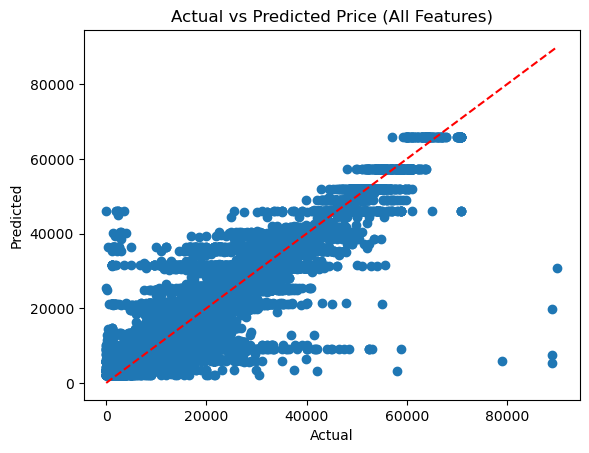

MAE: 2439.8713
MSE: 16266120.6064
R^2: 0.9162

==== Training with Selected Features ====


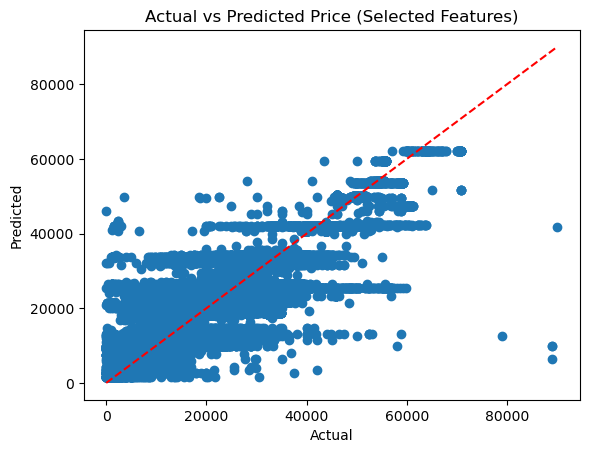

MAE: 4166.0318
MSE: 36732604.4867
R^2: 0.8108

==== Final Results Comparison ====
         Feature Set          MAE           MSE       R^2
0       All Features  2439.871345  1.626612e+07  0.916196
1  Selected Features  4166.031824  3.673260e+07  0.810752


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# 讀取資料
file_path = 'final.json'  # 請替換為你的檔案路徑
data = pd.read_json(file_path)

# 類別欄位和數值欄位
categorical_cols = ['廠商', '型號', '顏色', '地區', '福利品', '配件', '全新', '記憶體']
numerical_cols = ['容量', '電池健康度', '日期', '上市日', '資料抓取日', '保固時長', 
                     '抓取日建議售價', '上市日建議售價']

# 只保留資料中實際存在的欄位
categorical_cols = [col for col in categorical_cols if col in data.columns]
numerical_cols = [col for col in numerical_cols if col in data.columns]

# 處理日期型欄位，轉換為時間戳記
date_cols = ['日期', '上市日', '資料抓取日']
for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce').astype('int64') // 10**9

# 使用 LabelEncoder 進行類別型特徵編碼
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 定義所有特徵與選擇特徵
all_features = categorical_cols + numerical_cols
selected_features = [col for col in ['廠商', '型號', '容量', '電池健康度', '日期', '上市日', '資料抓取日'] if col in data.columns]

# 儲存結果
results = []

# 迭代兩種特徵選擇策略
for feature_set, feature_name in zip([all_features, selected_features], ['All Features', 'Selected Features']):
    print(f'\n==== Training with {feature_name} ====')

    # 設定 X, y
    X = data[feature_set]
    y = data['金額']

    # 拆分訓練與測試集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # 設定隨機森林模型
    model = RandomForestRegressor(
        n_estimators=200,   # 樹的數量
        max_depth=6,       # 樹的最大深度
        min_samples_split=3, # 內部節點再劃分所需的最小樣本數
        min_samples_leaf=50,  # 葉節點的最小樣本數
        random_state=42     # 固定隨機數，確保可復現
    )
    # 訓練模型
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估模型
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 儲存結果
    results.append({
        'Feature Set': feature_name,
        'MAE': mae,
        'MSE': mse,
        'R^2': r2
    })

    # 視覺化結果
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Price ({feature_name})')
    plt.show()

    # 輸出結果
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R^2: {r2:.4f}')

# 顯示最終結果
results_df = pd.DataFrame(results)
print('\n==== Final Results Comparison ====')
print(results_df)


In [3]:
import json
import numpy as np

# 自訂 JSON 序列化函式
def json_converter(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

# 將結果儲存成 JSON 檔案
results = {
    "MAE": mae,
    "MSE": mse,
    "R^2": r2,
    "Feature Importance": dict(zip(X.columns, model.feature_importances_))
}

# 根據模型名稱指定檔案名稱
model_name = "random_forest"  # 換成 lightgbm 或 xgboost random_forest
file_name = f"{model_name}_results.json"

# 儲存為 JSON
with open(file_name, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4, default=json_converter)

print(f"結果已儲存至 {file_name}")


結果已儲存至 random_forest_results.json
